In this notebook we look for interactions between the odor and the v_fwd representations in G4S.

In [1]:
%matplotlib inline
from copy import deepcopy
from itertools import product as cproduct
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression, Ridge

from aux import Generic
from data import DataLoader, random_chunk_split
from db import make_session, d_models
from lin_fit import fit_h_train_test, calc_r2
from plot import set_font_size, unity_line

import CONFIG as C

### Parameters

In [2]:
TRAIN_LEN = 32  # s
TEST_LEN = 8  # s

EXPTS = ['white_odor_fluct']
TARG = 'g4s'

WDW = (-3, 1)

METHOD = 'built-in'
PARAMS = {'model': LinearRegression}

### Resuable subroutines

Linear models

In [3]:
class ModelO(object):
    
    name = 'O'
    
    def __init__(self, trial):
        
        # run odor_binary --> TARG fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['odor_binary'],
            y_name=TARG,
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS,
            normed=True,
            C=C)

In [4]:
class ModelVF(object):
    
    name = 'VF'
    
    def __init__(self, trial):
        
        # run v_fwd --> TARG fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['v_fwd'],
            y_name=TARG,
            wdws={'v_fwd': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS,
            normed=True,
            C=C)

In [5]:
class ModelOVFI(object):
    
    name = 'OVFI'
    
    def __init__(self, trial):
        
        # run odor_binary --> TARG fit
        self.o = fit_h_train_test(
            trial=trial,
            x_names=['odor_binary'],
            y_name=TARG,
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS,
            normed=True,
            C=C)
        
        # run v_fwd --> TARG fit
        self.vf = fit_h_train_test(
            trial=trial,
            x_names=['v_fwd'],
            y_name=TARG,
            wdws={'v_fwd': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS,
            normed=True,
            C=C)
        
        self.trial_name = trial.name
        self.y_name = TARG
        
        self.train = self.o.train & self.vf.train
        self.test = self.o.test & self.vf.test
        self.t = self.o.t
        
        self.y = self.o.y
        
        self.y_hat_train = self.o.y_hat_train + self.vf.y_hat_train
        self.y_hat_test = self.o.y_hat_test + self.vf.y_hat_test
        
        self.r2_train = calc_r2(self.y, self.y_hat_train)
        self.r2_test = calc_r2(self.y, self.y_hat_test)

In [6]:
class ModelOVFJ(object):
    
    name = 'OVFJ'
    
    def __init__(self, trial):
        
        # run joint (odor_binary, v_fwd) --> TARG fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['odor_binary', 'v_fwd'],
            y_name=TARG,
            wdws={'odor_binary': WDW, 'v_fwd': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS,
            normed=True,
            C=C)

### Plot true vs predicted G4S for each trial/model

In [7]:
# load trials
session = make_session()
trials = session.query(d_models.Trial).filter(
    d_models.Trial.expt.in_(EXPTS)).all()
session.close()

# load data and create a moving average 
for trial in trials:
    trial.dl = DataLoader(trial, 0, None)

In [8]:
# fit models
models = {}

for model_class in [ModelO, ModelVF, ModelOVFI, ModelOVFJ]:
    
    models_ = {trial.name: model_class(trial) for trial in trials}
    models[model_class.name] = models_

In [9]:
AX_GRID = (len(trials), len(models))
AX_H = 3.5
FIG_SIZE = (16, AX_H*AX_GRID[0])

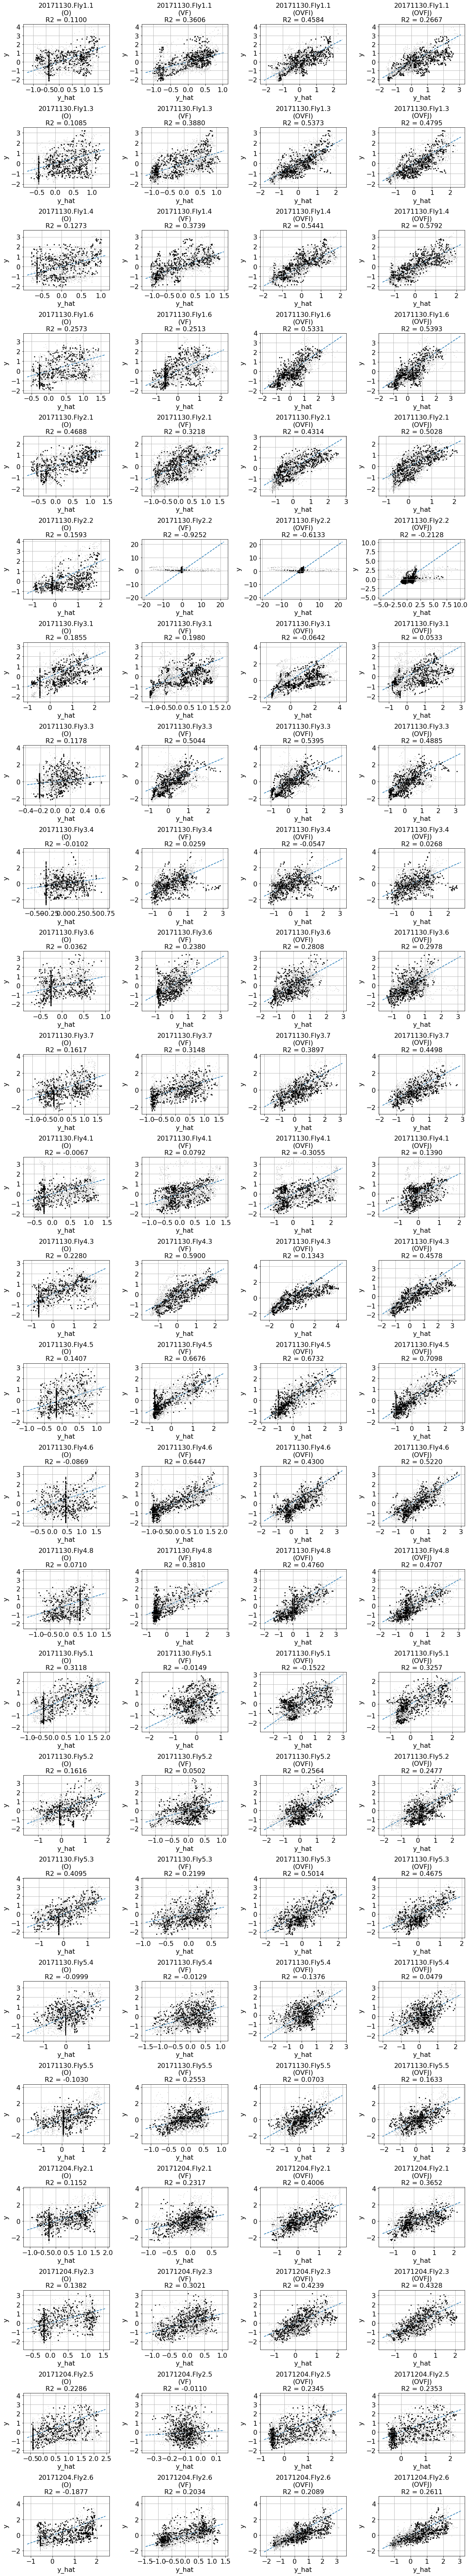

In [10]:
fig, axs = plt.subplots(*AX_GRID, figsize=FIG_SIZE, tight_layout=True)

for trial, ax_row in zip(trials, axs):
    for model_class, ax in zip([ModelO, ModelVF, ModelOVFI, ModelOVFJ], ax_row):
        
        model = models[model_class.name][trial.name]
        
        if model.name != 'OVFI':
            
            y = model.rslt.y
            y_hat_train = model.rslt.y_hat_train
            y_hat_test = model.rslt.y_hat_test
            r2_test = model.rslt.r2_test
            
        elif model.name == 'OVFI':
            
            y = model.y
            y_hat_train = model.y_hat_train
            y_hat_test = model.y_hat_test
            r2_test = model.r2_test
            
        ax.scatter(y_hat_train, y, lw=0, c='gray', s=1)
        ax.scatter(y_hat_test, y, lw=0, c='k', s=8)
        
        unity_line(ax, *ax.get_xlim(), ls='--', zorder=-1)
        
        ax.grid()

        ax.set_title('{0}\n({1})\nR2 = {2:.4f}'.format(trial.name, model.name, r2_test))
            
for ax in axs.flatten():
    ax.set_xlabel('y_hat')
    ax.set_ylabel('y')
    set_font_size(ax, 16)

### Make bar plot of R2 values

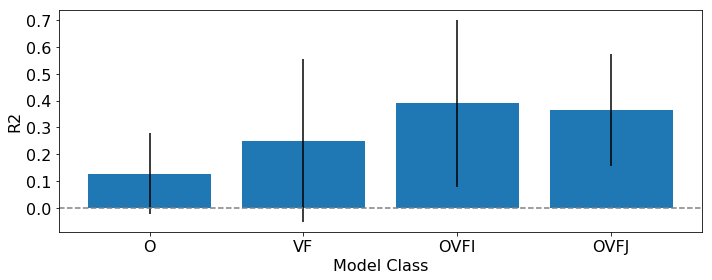

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)

r2_mdns = []
r2_stds = []

for model_class in [ModelO, ModelVF, ModelOVFI, ModelOVFJ]:
    
    r2s = []
    
    for trial in trials:
        model = models[model_class.name][trial.name]
        
        if model.name != 'OVFI':
            r2 = model.rslt.r2_test
        elif model.name == 'OVFI':
            r2 = model.r2_test
            
        r2s.append(r2)
        
    r2_mdns.append(np.nanmedian(r2s))
    r2_stds.append(np.nanstd(r2s))
    
x_bar = np.arange(len(r2_mdns))
x_ticks = x_bar
x_tick_labels = [model_class.name for model_class in [ModelO, ModelVF, ModelOVFI, ModelOVFJ]]

ax.bar(x_bar, r2_mdns, yerr=r2_stds, align='center')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

ax.axhline(0, color='gray', ls='--')

ax.set_xlabel('Model Class')
ax.set_ylabel('R2')

set_font_size(ax, 16)

In [12]:
r2_mdns

[0.1272936970088675,
 0.25131258329601081,
 0.38973455144409752,
 0.36519509354945323]

### Show filters

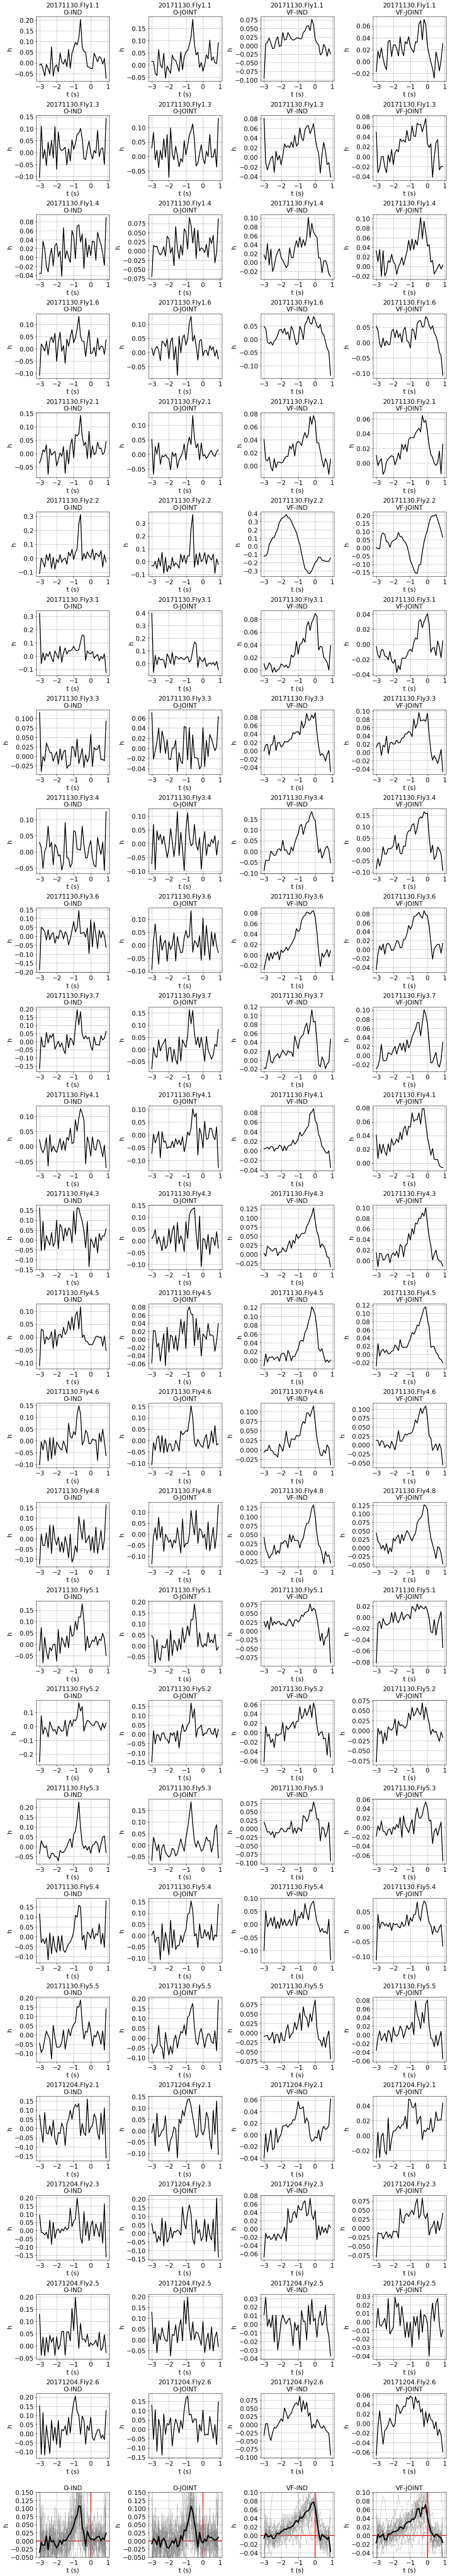

In [13]:
AX_GRID = (len(trials) + 1, len(models))
AX_H = 3.5
FIG_SIZE = (16, AX_H*AX_GRID[0])

fig, axs = plt.subplots(*AX_GRID, figsize=FIG_SIZE, tight_layout=True)

labels = ['O-IND', 'O-JOINT', 'VF-IND', 'VF-JOINT']

t_hs = {label: [] for label in labels}
hs = {label: [] for label in labels}

y_lims = {
    'O-IND': (-0.05, .15), 'O-JOINT': (-0.05, .15),
    'VF-IND': (-0.05, 0.1), 'VF-JOINT': (-0.05, 0.1),
}

# plot individual trial filters
for trial, ax_row in zip(trials, axs):
    for ctr, ax in enumerate(ax_row):
        
        if ctr == 0:
            # O independent
            
            model = models['O'][trial.name]
            t_h = model.rslt.t_hs['odor_binary']
            h = model.rslt.hs['odor_binary']
            
            label = 'O-IND'

        elif ctr == 1:
            # O joint
            
            model = models['OVFJ'][trial.name]
            t_h = model.rslt.t_hs['odor_binary']
            h = model.rslt.hs['odor_binary']
            
            label = 'O-JOINT'
            
        elif ctr == 2:
            # VF independent
            
            model = models['VF'][trial.name]
            t_h = model.rslt.t_hs['v_fwd']
            h = model.rslt.hs['v_fwd']
            
            label = 'VF-IND'
            
        elif ctr == 3:
            # VF joint
            
            model = models['OVFJ'][trial.name]
            t_h = model.rslt.t_hs['v_fwd']
            h = model.rslt.hs['v_fwd']
            
            label = 'VF-JOINT'
            
        ax.plot(t_h, h, lw=2, c='k')
        ax.set_title('{}\n{}'.format(trial.name, label))
        
        t_hs[label].append(t_h)
        hs[label].append(h)

# plot mean filters
t_hs_mean = {label: np.nanmedian(t_hs[label], 0) for label in labels}
hs_mean = {label: np.nanmedian(hs[label], 0) for label in labels}

for label, ax in zip(labels, axs[-1, :]):
    
    ax.axhline(0, c='r', lw=2)
    ax.axvline(0, c='r', lw=2)
    
    ax.plot(t_hs_mean[label], np.array(hs[label]).T, lw=0.5, color='gray')
    ax.plot(t_hs_mean[label], hs_mean[label], lw=3, color='k')

    ax.set_ylim(y_lims[label])
    
    ax.set_title(label)
    
        
for ax in axs.flatten():
    
    ax.grid()
    
    ax.set_xlabel('t (s)')
    ax.set_ylabel('h')
    
    set_font_size(ax, 16)

In [14]:
fig.savefig('temp.png', dpi=300)

# Run per-trial statistical tests for interaction terms

$H_0: g4s(t) = a_0 + b_oo(t) + b_{vf}vf(t)$

$H_1: g4s(t) = a_0 + b_oo(t) + b_{vf}vf(t) + b_{ovf}o(t)vf(t)$

In [15]:
from data import random_shift

def fit_nested(o, vf, y):
    """
    Fit nested interaction model and return coefs, rss.
    """
    # get interaction term
    ovf = o * vf
    
    x = np.array([o, vf, ovf]).T
    
    valid = np.all(~np.isnan(x), 1) & (~np.isnan(y))
    
    # fit null (non-interacting) model
    rgr_null = LinearRegression()
    rgr_null.fit(x[valid, :2], y[valid])
    
    y_hat_null = np.nan * np.zeros(len(y))
    y_hat_null[valid] = rgr_null.predict(x[valid, :2])
    
    r2_null = calc_r2(y, y_hat_null)
    
    coef_null = {
        'a': rgr_null.intercept_,
        'b_o': rgr_null.coef_[0],
        'b_vf': rgr_null.coef_[1],
    }
    
    # fit interacting model
    rgr_iatn = LinearRegression()
    rgr_iatn.fit(x[valid, :], y[valid])
    
    y_hat_iatn = np.nan * np.zeros(len(y))
    y_hat_iatn[valid] = rgr_iatn.predict(x[valid, :])
    
    r2_iatn = calc_r2(y, y_hat_iatn)
    
    coef_iatn = {
        'a': rgr_iatn.intercept_,
        'b_o': rgr_iatn.coef_[0],
        'b_vf': rgr_iatn.coef_[1],
        'b_ovf': rgr_iatn.coef_[2],
    }
    
    return Generic(
        r2_null=r2_null,
        coef_null=coef_null,
        r2_iatn=r2_iatn,
        coef_iatn=coef_iatn,
        rss=r2_iatn-r2_null)
    

def iatn_test(trial, n_shuffles, models):
    """
    Test for interactions between the odor and v_fwd representations in a given trial.
    
    :return: intcn_test_rslt instance with attributes:
        coef_null: {'a': ..., 'b_o': ..., 'b_vf': ...}
        coef_iatn: {'a': ..., 'b_o': ..., 'b_vf': ..., 'b_ovf': ...}
        r2_null: R2 for non-interacting model
        r2_iatn: R2 for interacting model
        rss: residual sum of squares (how much better iatn model is than null model)
        rss_shuffled: shuffled rss values
        n_shuffles: how many shuffles used to calculate p-value
        p_val: p-value
    """
    
    # get o and vf
    model = models['OVFI'][trial.name]
    
    o = np.nan * np.zeros(len(trial.dl.t))
    
    o[model.train] = model.o.y_hat_train[model.train]
    o[model.test] = model.o.y_hat_test[model.test]
    
    vf = np.nan * np.zeros(len(trial.dl.t))
    
    vf[model.train] = model.vf.y_hat_train[model.train]
    vf[model.test] = model.vf.y_hat_test[model.test]
    
    g4s = model.y
    
    # fit nested models
    nested_rslt = fit_nested(o, vf, g4s)
    
    # fit shuffled models
    rss_shuffled = np.nan * np.zeros(n_shuffles)
    r2_null_shuffled = np.nan * np.zeros(n_shuffles)
    r2_iatn_shuffled = np.nan * np.zeros(n_shuffles)
    
    for ctr in range(n_shuffles):
        
        x = np.array([o, vf]).T
        o_shuffled, vf_shuffled = random_shift(x).T
        
        nested_rslt_shuffled = fit_nested(o_shuffled, vf_shuffled, g4s)
        
        rss_shuffled[ctr] = nested_rslt_shuffled.rss
        r2_null_shuffled[ctr] = nested_rslt_shuffled.r2_null
        r2_iatn_shuffled[ctr] = nested_rslt_shuffled.r2_iatn
        
    # calculate p-value
    p_val = np.mean(rss_shuffled >= nested_rslt.rss)
    
    return Generic(
        coef_null=nested_rslt.coef_null,
        coef_iatn=nested_rslt.coef_iatn,
        r2_null=nested_rslt.r2_null,
        r2_iatn=nested_rslt.r2_iatn,
        rss=nested_rslt.rss,
        rss_shuffled=rss_shuffled,
        r2_null_shuffled=r2_null_shuffled,
        r2_iatn_shuffled=r2_iatn_shuffled,
        n_shuffles=n_shuffles,
        p_val=p_val)

In [16]:
np.random.seed(0)

N_SHUFFLES = 2000

rslts_iatn = {trial.name: iatn_test(trial, N_SHUFFLES, models) for trial in trials}

In [17]:
columns = ['R2_NULL', 'R2_IATN', 'RSS', 'P_VAL', 'COEF']

df = pd.DataFrame(columns=columns, index=[trial.name for trial in trials])

for trial_name, rslt_iatn in rslts_iatn.items():
    
    df.loc[trial_name]['R2_NULL'] = rslt_iatn.r2_null
    df.loc[trial_name]['R2_IATN'] = rslt_iatn.r2_iatn
    df.loc[trial_name]['RSS'] = rslt_iatn.rss
    df.loc[trial_name]['P_VAL'] = rslt_iatn.p_val
    
    df.loc[trial_name]['COEF'] = rslt_iatn.coef_iatn['b_ovf']
    
df

,R2_NULL,R2_IATN,RSS,P_VAL,COEF
20171130.Fly1.1,0.516189,0.516263,7.38016e-05,0.901,0.0239156
20171130.Fly1.3,0.594907,0.616842,0.021935,0.07,0.453299
20171130.Fly1.4,0.635887,0.636304,0.000416695,0.8075,0.0585734
20171130.Fly1.6,0.55836,0.583345,0.0249857,0.037,0.417085
20171130.Fly2.1,0.565263,0.591692,0.0264296,0.021,-0.580864
20171130.Fly2.2,0.339782,0.353542,0.0137599,0.0395,-0.043395
20171130.Fly3.1,0.243549,0.252555,0.00900627,0.254,-0.184181
20171130.Fly3.3,0.375304,0.381448,0.0061437,0.2725,-0.853171
20171130.Fly3.4,0.241277,0.243308,0.00203166,0.454,-0.290667
20171130.Fly3.6,0.332424,0.334323,0.00189942,0.484,0.206012


In [18]:
t_control = trials[0].dl.t.copy()
train_control = models['OVFI'][trials[0].name].train
test_control = models['OVFI'][trials[0].name].test

o_control = np.random.normal(0, 1, t_control.shape)
vf_control = np.random.normal(0, 1, t_control.shape)
g4s = o_control + vf_control + (o_control*vf_control) + np.random.normal(0, .1, t_control.shape)

y_hat_train_o = np.nan * np.zeros(t_control.shape)
y_hat_train_o[train_control] = o_control[train_control]
y_hat_test_o = np.nan * np.zeros(t_control.shape)
y_hat_test_o[test_control] = o_control[test_control]

y_hat_train_vf = np.nan * np.zeros(t_control.shape)
y_hat_train_vf[train_control] = vf_control[train_control]
y_hat_test_vf = np.nan * np.zeros(t_control.shape)
y_hat_test_vf[test_control] = vf_control[test_control]

trial_control = Generic(name='control', dl=Generic(t=t_control))
model_control = Generic(
    train=train_control,
    test=test_control,
    o=Generic(y_hat_train=y_hat_train_o, y_hat_test=y_hat_test_o),
    vf=Generic(y_hat_train=y_hat_train_vf, y_hat_test=y_hat_test_vf),
    y=g4s,
)

rslt_iatn_control = iatn_test(trial_control, N_SHUFFLES, {'OVFI': {'control': model_control}})

print('Control p-value with known interaction term:')
print(rslt_iatn_control.p_val)

print('R2 (non-interacting):')
print(rslt_iatn_control.r2_null)

print('R2 (interaction):')
print(rslt_iatn_control.r2_iatn)

Control p-value with known interaction term:
0.001
R2 (non-interacting):
0.683019645106
R2 (interaction):
0.996454409196
